In [1]:
import tensorflow as tf
from tensorflow.contrib import predictor

export_dir = "model_sr50_new"
predict_fn = predictor.from_saved_model(export_dir)

INFO:tensorflow:Restoring parameters from model_sr50_new/variables/variables


In [2]:
from matplotlib import pyplot as plt
import numpy as np
import random

In [3]:
import sys 
sys.path.insert(0,'..')
sys.path.insert(0,'../..')

In [4]:
from cnf_dataset import clauses_to_matrix
from dpll import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [5]:
import math
from collections import defaultdict

def jw(clauses):
    score = defaultdict(int)

    for clause in clauses:
        for l in clause:
            score[l] += 2. ** (-len(clause))

    return max(score, key=score.get)


In [6]:
LIMIT_RUNS = 1000

In [7]:
def shorten_cnf(cnf: CNF):
    for c in cnf.clauses:
        if len(c) == 1:
            # print("Chosen lone clause", c[0])
            return shorten_cnf(cnf.set_var(c[0]))
    all_literals = set(x
                       for clause in cnf.clauses
                       for x in clause)
    for v in cnf.vars:
        if v in all_literals and (-v) not in all_literals:
            # print("Chosen lone literal", v)
            return shorten_cnf(cnf.set_var(v))
        if (-v) in all_literals and v not in all_literals:
            # print("Chosen lone literal", -v)
            return shorten_cnf(cnf.set_var(-v))
    return cnf

def make_normalized(cls):
    class NormalizedDPLL(cls):
        def run(self, cnf: CNF):
            assert isinstance(cnf, CNF)
            self.number_of_runs += 1
            if self.number_of_runs > LIMIT_RUNS:
                return None
            
            cnf = shorten_cnf(cnf)
            if cnf.is_true():
                return []
            elif cnf.is_false():
                return None

            sug_var = self.suggest(cnf)
            sug_cnf = cnf.set_var(sug_var)

            sug_res = self.run(sug_cnf)
            if sug_res is not None:
                return [sug_var] + sug_res

            not_sug_cnf = cnf.set_var(-sug_var)
            not_sug_res = self.run(not_sug_cnf)
            if not_sug_res is not None:
                self.number_of_errors += 1
                return [-sug_var] + not_sug_res
            return None
    NormalizedDPLL.__name__ = "Normalized{}".format(cls.__name__)
    return NormalizedDPLL

In [8]:
np.set_printoptions(precision=3, suppress=True)

In [9]:
import tensorflow as tf
import os

BATCH_SIZE = 1

In [10]:
# Because we have to pass full batch

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = predict_fn({"input": inputs})['policy_probabilities']
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        return best_svar

class MostCommonDPLL(DPLL):
    def suggest(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]
    
class JeroslawDPLL(DPLL):
    def suggest(self, cnf: CNF):
        return jw(cnf.clauses)

In [11]:
NormalizedGraphBasedDPLL = make_normalized(GraphBasedDPLL)
NormalizedMostCommonDPLL = make_normalized(MostCommonDPLL)
NormalizedJeroslawDPLL = make_normalized(JeroslawDPLL)

In [12]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    solved = 0
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        if res is not None:
            steps.append(dpll.number_of_runs)
            errors.append(dpll.number_of_errors)
            solved += 1
    print("Within {} steps solved {} problems out of {}".format(LIMIT_RUNS, solved, len(sats)))
    return steps, errors

In [13]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [14]:
# s - number of samples
# n - max number of clauses, use 100 * m
# m - number of variables

def print_all(s, n, m, light=False):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    
    random.seed(1)
    np.random.seed(1)
    
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        sats.append(sat)
    assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    compute_and_print_steps(sats, NormalizedGraphBasedDPLL)
    compute_and_print_steps(sats, NormalizedMostCommonDPLL)
    compute_and_print_steps(sats, NormalizedJeroslawDPLL)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [01:25<00:00,  1.20it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 5.59; stdev step: 3.00; avg error: 0.02; stdev error: 0.14


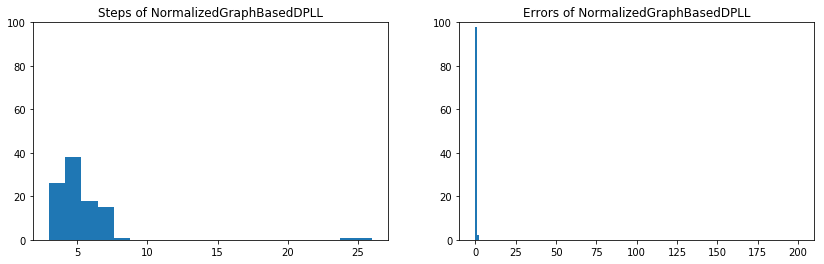

100%|██████████| 100/100 [00:00<00:00, 270.47it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.16; stdev step: 4.03; avg error: 0.83; stdev error: 0.71


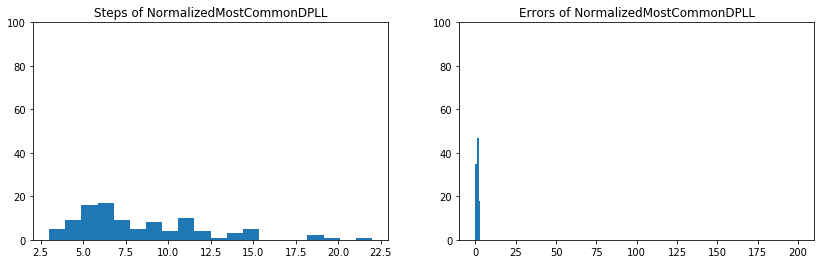

100%|██████████| 100/100 [00:00<00:00, 293.28it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 7.31; stdev step: 3.60; avg error: 0.49; stdev error: 0.56


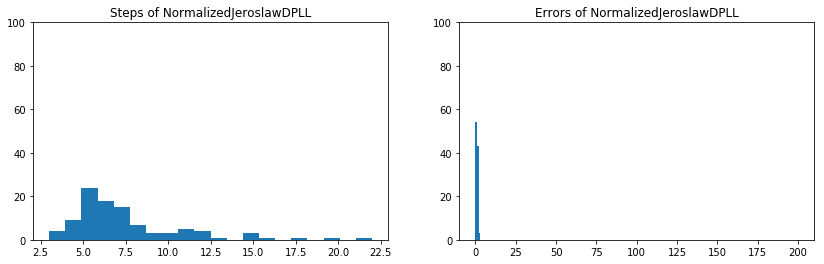

In [15]:
print_all(100, 200, 10)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [01:26<00:00,  1.25it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 6.44; stdev step: 2.54; avg error: 0.03; stdev error: 0.17


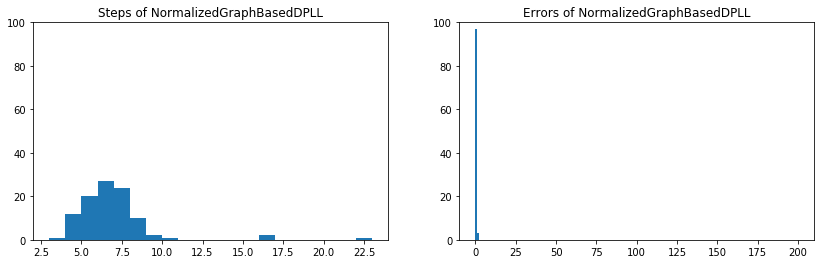

100%|██████████| 100/100 [00:00<00:00, 149.37it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.27; stdev step: 5.75; avg error: 1.09; stdev error: 0.87


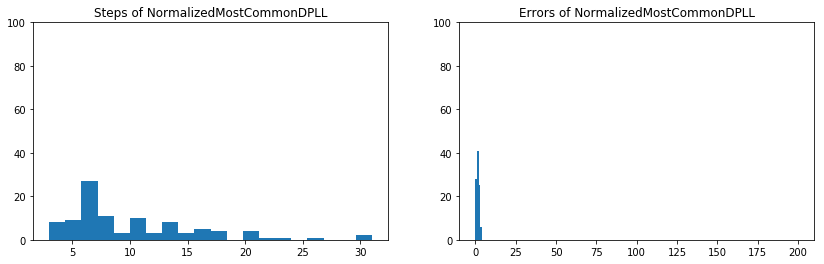

100%|██████████| 100/100 [00:00<00:00, 284.53it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.86; stdev step: 4.90; avg error: 0.65; stdev error: 0.68


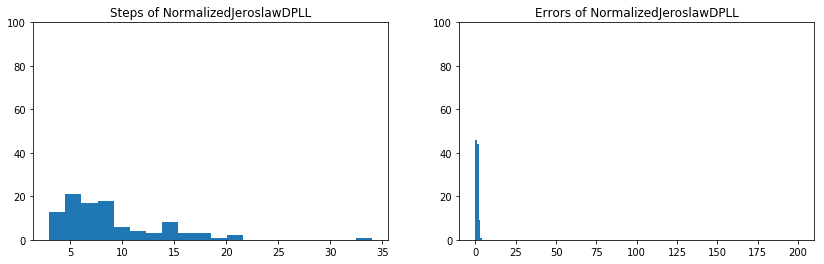

In [16]:
print_all(100, 200, 12)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [02:10<00:00,  1.32s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 8.79; stdev step: 8.92; avg error: 0.06; stdev error: 0.24


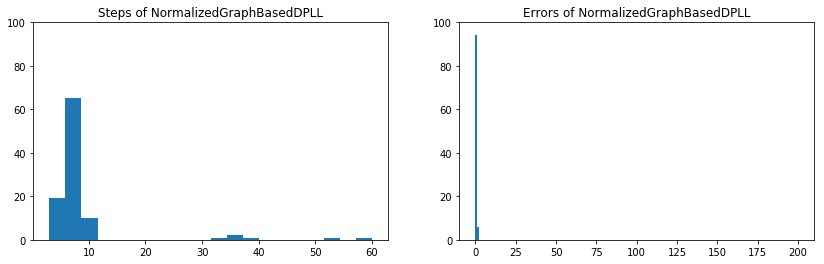

100%|██████████| 100/100 [00:00<00:00, 156.20it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 11.90; stdev step: 7.81; avg error: 1.13; stdev error: 0.88


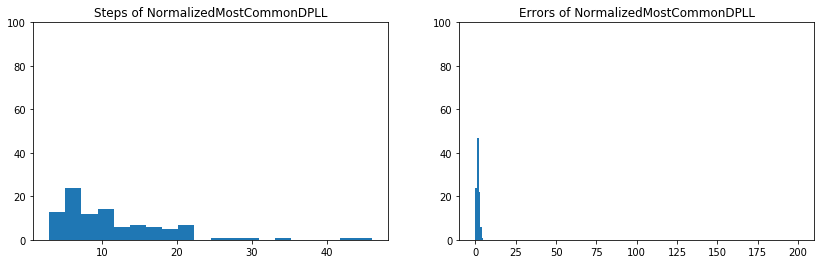

100%|██████████| 100/100 [00:01<00:00, 79.24it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.61; stdev step: 6.12; avg error: 0.80; stdev error: 0.73


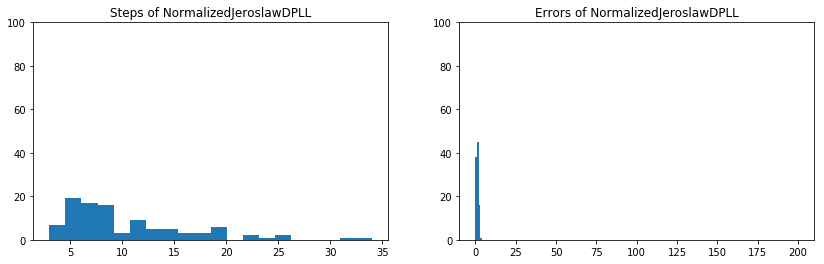

In [17]:
print_all(100, 200, 14)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [02:30<00:00,  1.48s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 10.08; stdev step: 9.37; avg error: 0.10; stdev error: 0.30


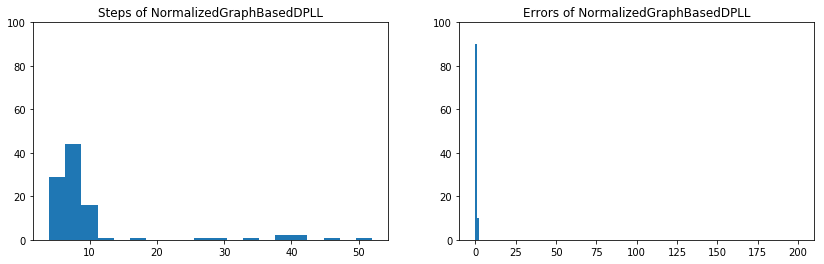

100%|██████████| 100/100 [00:01<00:00, 59.25it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 15.44; stdev step: 10.14; avg error: 1.33; stdev error: 0.88


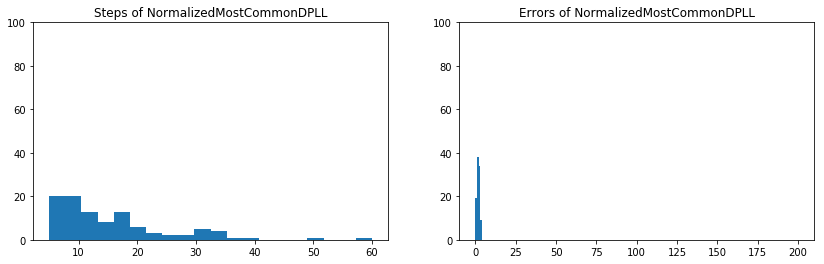

100%|██████████| 100/100 [00:01<00:00, 75.77it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 11.89; stdev step: 6.72; avg error: 0.89; stdev error: 0.66


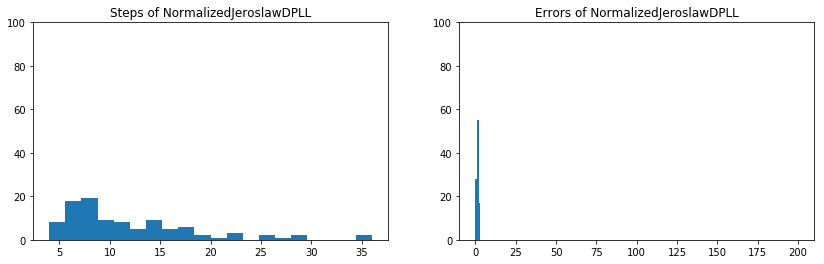

In [18]:
print_all(100, 200, 16)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [03:08<00:00,  2.15s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 12.07; stdev step: 13.78; avg error: 0.11; stdev error: 0.34


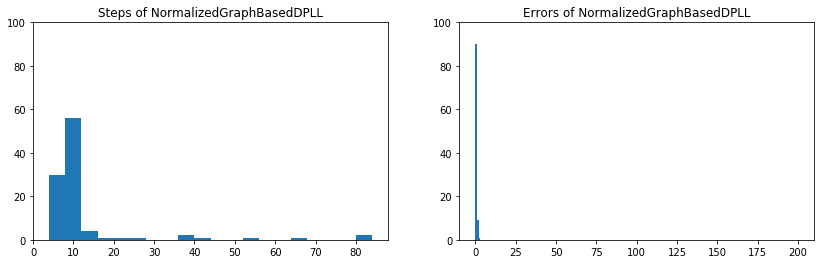

100%|██████████| 100/100 [00:01<00:00, 57.65it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 18.27; stdev step: 12.14; avg error: 1.42; stdev error: 0.90


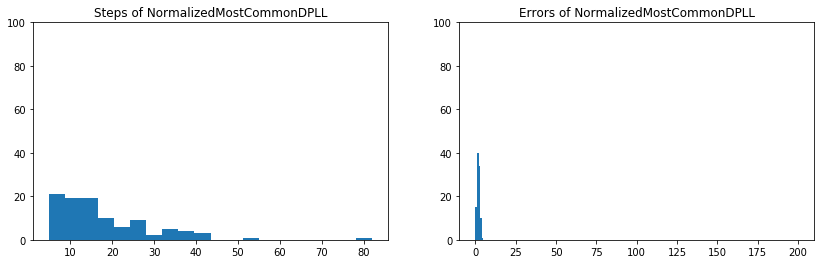

100%|██████████| 100/100 [00:01<00:00, 74.02it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 13.68; stdev step: 7.54; avg error: 0.96; stdev error: 0.76


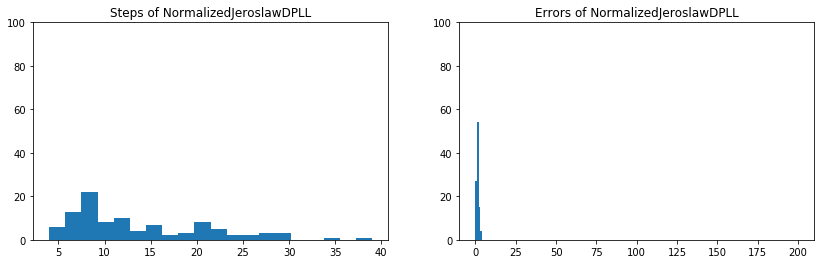

In [19]:
print_all(100, 200, 18)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [04:23<00:00,  2.38s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 19.24; stdev step: 28.70; avg error: 0.19; stdev error: 0.44


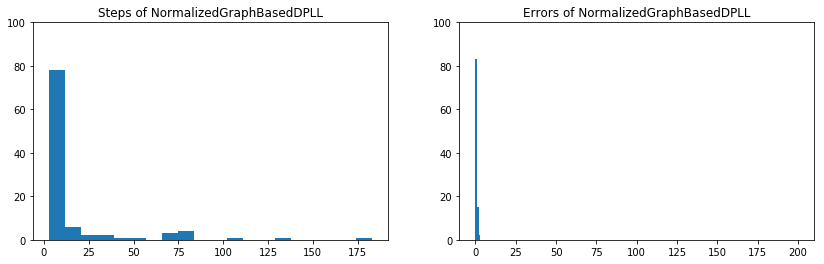

100%|██████████| 100/100 [00:02<00:00, 47.25it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 23.99; stdev step: 17.41; avg error: 1.60; stdev error: 1.07


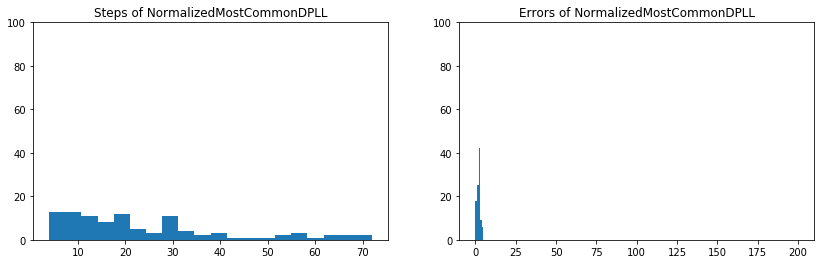

100%|██████████| 100/100 [00:01<00:00, 90.89it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 18.68; stdev step: 11.47; avg error: 1.14; stdev error: 0.74


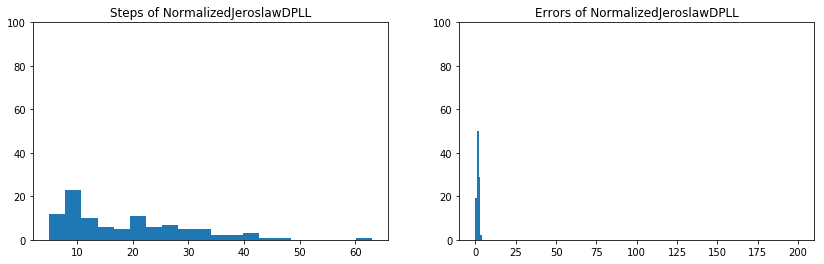

In [20]:
print_all(100, 200, 20)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [06:32<00:00,  3.01s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 21.43; stdev step: 33.62; avg error: 0.16; stdev error: 0.39


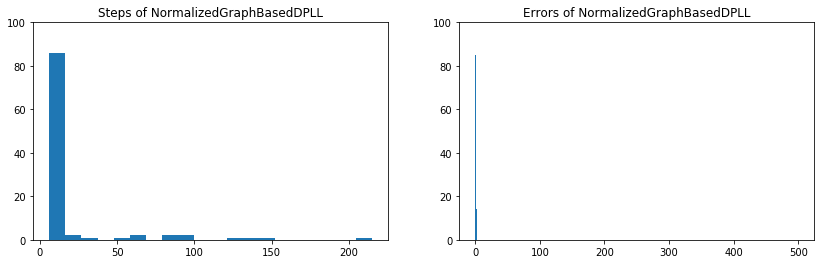

100%|██████████| 100/100 [00:05<00:00, 17.37it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 33.53; stdev step: 31.92; avg error: 1.73; stdev error: 1.14


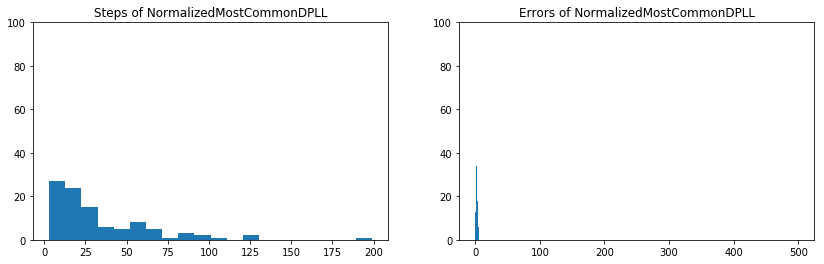

100%|██████████| 100/100 [00:02<00:00, 33.84it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 18.76; stdev step: 14.53; avg error: 1.05; stdev error: 0.83


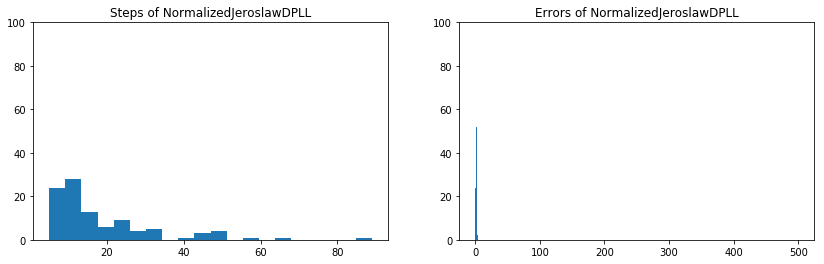

In [21]:
print_all(100, 500, 25, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [11:10<00:00,  7.29s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 41.01; stdev step: 81.64; avg error: 0.17; stdev error: 0.38


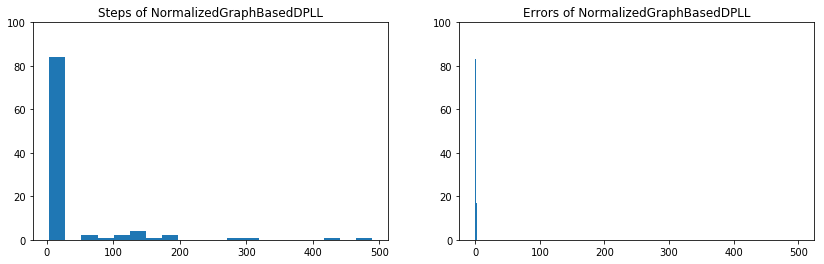

100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 54.77; stdev step: 49.99; avg error: 2.13; stdev error: 1.21


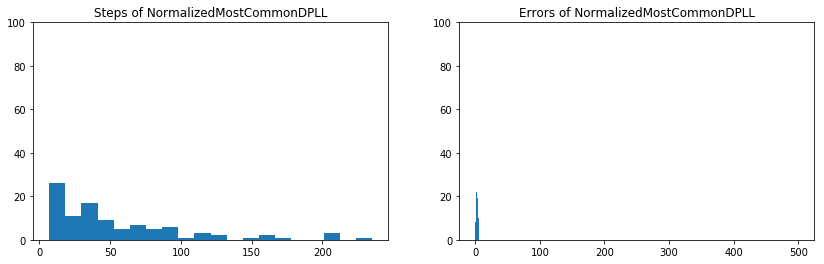

100%|██████████| 100/100 [00:08<00:00, 11.68it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 32.71; stdev step: 25.86; avg error: 1.23; stdev error: 0.80


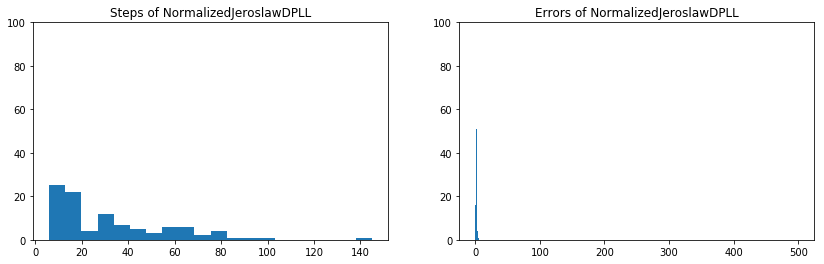

In [22]:
print_all(100, 500, 30, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [31:45<00:00, 22.36s/it]


Within 1000 steps solved 99 problems out of 100
#Sats: 99; avg step: 99.38; stdev step: 159.30; avg error: 0.37; stdev error: 0.58


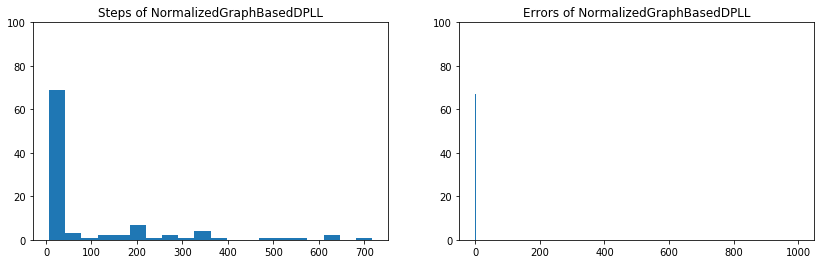

100%|██████████| 100/100 [01:01<00:00,  1.06s/it]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 198.68; stdev step: 165.04; avg error: 2.80; stdev error: 1.31


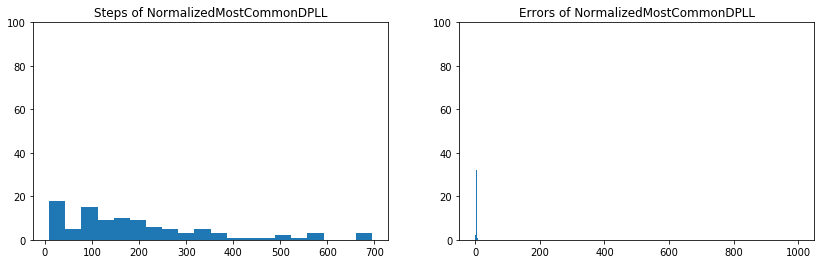

100%|██████████| 100/100 [00:25<00:00,  2.43it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 83.80; stdev step: 73.45; avg error: 1.84; stdev error: 1.12


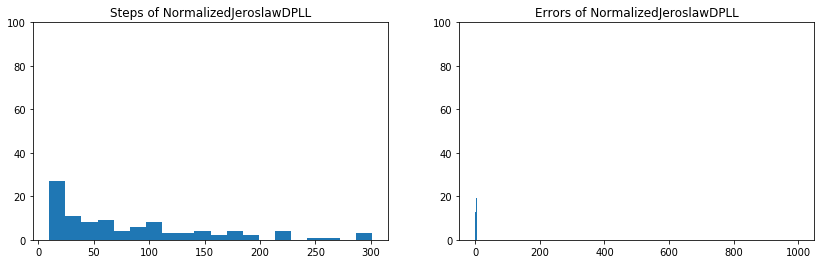

In [23]:
print_all(100, 1000, 40, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [50:16<00:00, 40.63s/it] 


Within 1000 steps solved 92 problems out of 100
#Sats: 92; avg step: 101.24; stdev step: 193.60; avg error: 0.27; stdev error: 0.51


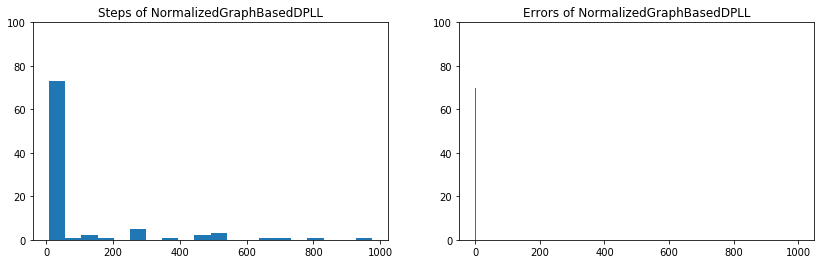

100%|██████████| 100/100 [03:34<00:00,  2.82s/it]


Within 1000 steps solved 82 problems out of 100
#Sats: 82; avg step: 356.94; stdev step: 268.94; avg error: 2.95; stdev error: 1.32


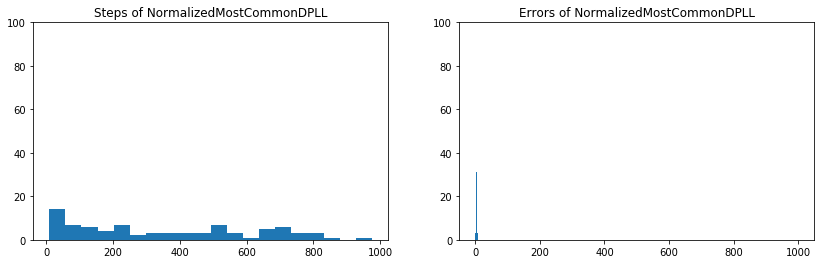

100%|██████████| 100/100 [00:51<00:00,  1.34it/s]


Within 1000 steps solved 100 problems out of 100
#Sats: 100; avg step: 152.69; stdev step: 146.97; avg error: 2.01; stdev error: 1.09


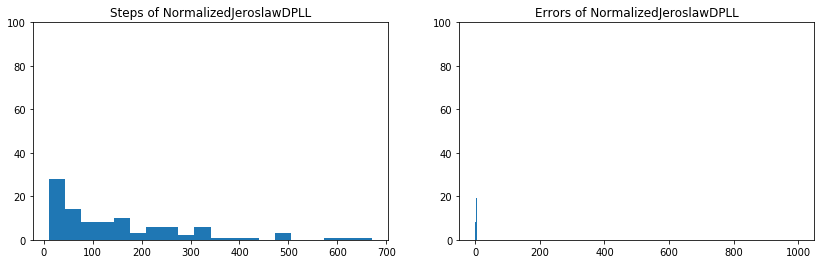

In [24]:
print_all(100, 1000, 50, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [2:06:24<00:00, 73.85s/it]  


Within 1000 steps solved 65 problems out of 100
#Sats: 65; avg step: 88.89; stdev step: 156.13; avg error: 0.25; stdev error: 0.50


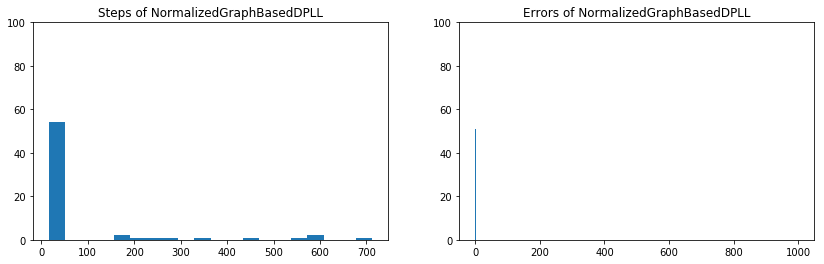

100%|██████████| 100/100 [06:41<00:00,  4.01s/it]


Within 1000 steps solved 24 problems out of 100
#Sats: 24; avg step: 370.75; stdev step: 307.04; avg error: 3.58; stdev error: 1.11


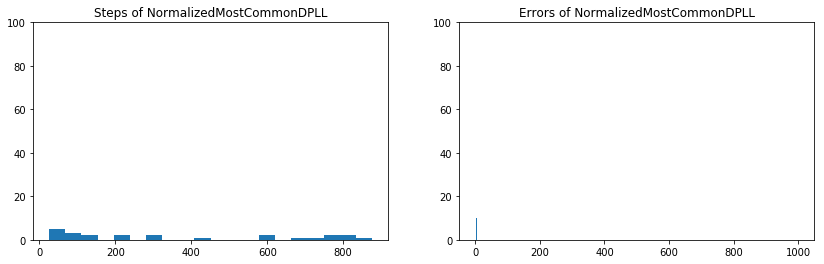

100%|██████████| 100/100 [04:17<00:00,  2.67s/it]


Within 1000 steps solved 72 problems out of 100
#Sats: 72; avg step: 375.93; stdev step: 282.15; avg error: 2.76; stdev error: 1.16


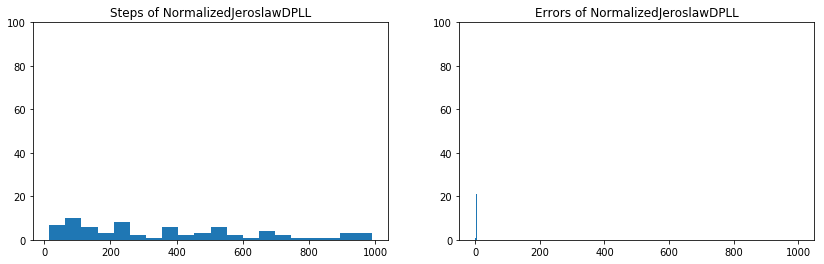

In [25]:
print_all(100, 1000, 70, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [3:03:27<00:00, 64.90s/it]  


Within 1000 steps solved 48 problems out of 100
#Sats: 48; avg step: 62.31; stdev step: 117.93; avg error: 0.23; stdev error: 0.51


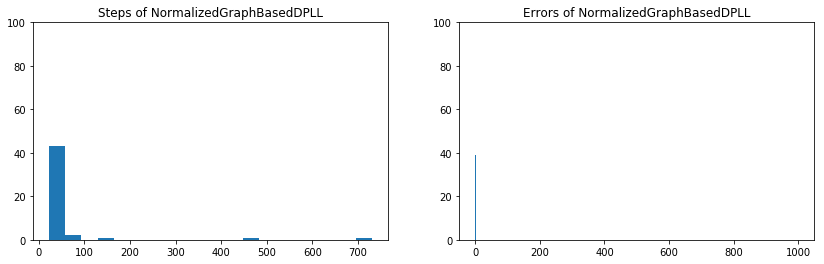

100%|██████████| 100/100 [11:50<00:00,  6.74s/it]


Within 1000 steps solved 10 problems out of 100
#Sats: 10; avg step: 418.80; stdev step: 272.65; avg error: 3.90; stdev error: 1.70


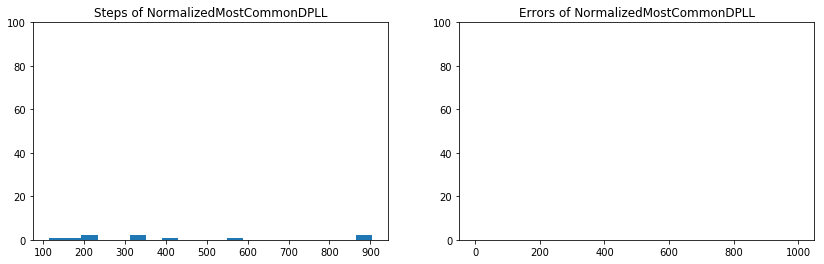

100%|██████████| 100/100 [13:01<00:00,  7.81s/it]


Within 1000 steps solved 37 problems out of 100
#Sats: 37; avg step: 356.16; stdev step: 318.20; avg error: 2.35; stdev error: 1.21


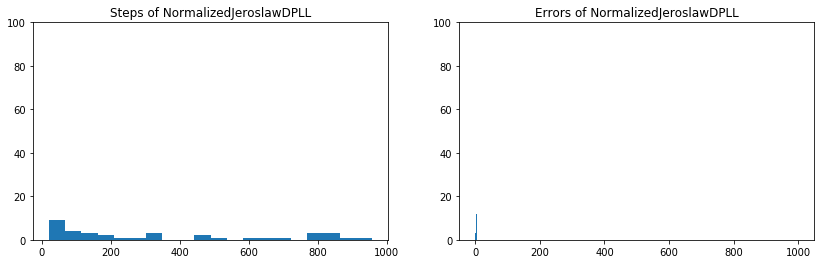

In [26]:
print_all(100, 1000, 90, light=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We have generated 100 formulas


100%|██████████| 100/100 [5:11:50<00:00, 204.84s/it] 


Within 1000 steps solved 22 problems out of 100
#Sats: 22; avg step: 60.73; stdev step: 71.35; avg error: 0.18; stdev error: 0.39


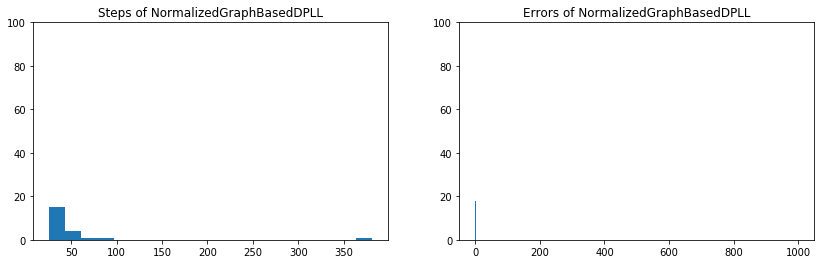

100%|██████████| 100/100 [18:18<00:00, 10.92s/it]


Within 1000 steps solved 1 problems out of 100
#Sats: 1; avg step: 415.00; stdev step: 0.00; avg error: 2.00; stdev error: 0.00


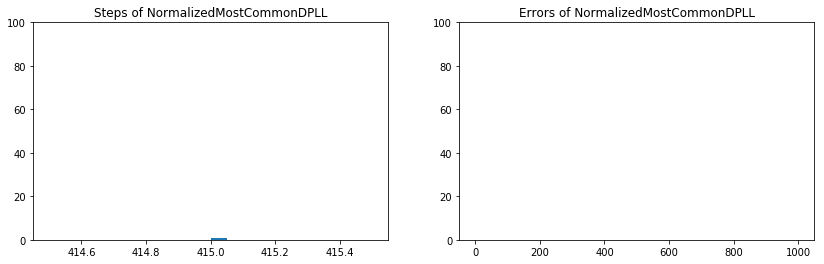

100%|██████████| 100/100 [15:48<00:00,  6.49s/it]


Within 1000 steps solved 11 problems out of 100
#Sats: 11; avg step: 240.73; stdev step: 184.97; avg error: 2.82; stdev error: 0.83


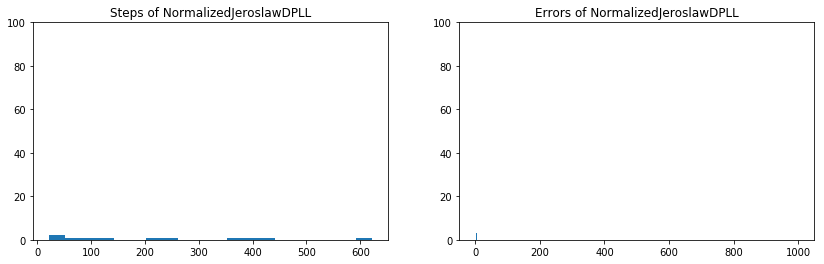

In [27]:
print_all(100, 1000, 110, light=True)